In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

## Data preprocessing

In [2]:
# get data
from ler.utils import append_json, load_json
import numpy as np
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(waveform_approximant='IMRPhenomXPHM', minimum_frequency=10., snr_type='inner_product')

psds not given. Choosing bilby's default psds
npool:  4
snr type:  inner_product
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  10.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=10.0): 369.97199706893525


In [10]:
# data generation
def samples(nsamples = 25000, json_file='samplesL1.json'):
    unlensed_param = {}
    mtot = np.random.uniform(1,370, size=nsamples)
    mass_ratio = np.random.uniform(0.1,1,size=nsamples)
    unlensed_param['mass_1'] = mtot/(1+mass_ratio)
    unlensed_param['mass_2'] = mtot/(1+1/mass_ratio)
    unlensed_param['luminosity_distance'] = np.random.uniform(1,10000, size=nsamples)
    unlensed_param['theta_jn'] = np.random.uniform(0,np.pi, size=nsamples)
    unlensed_param['ra'] = np.random.uniform(0,2*np.pi, size=nsamples)
    unlensed_param['dec'] = np.random.uniform(0,np.pi, size=nsamples)
    unlensed_param['psi'] = np.random.uniform(0,np.pi, size=nsamples)
    unlensed_param['phase'] = np.random.uniform(0,2*np.pi, size=nsamples)
    unlensed_param['a_1'] = np.random.uniform(0,0.99, size=nsamples)
    unlensed_param['a_2'] = np.random.uniform(0,0.99, size=nsamples)
    unlensed_param['tilt_1'] = np.random.uniform(0,np.pi, size=nsamples)
    unlensed_param['tilt_2'] = np.random.uniform(0,np.pi, size=nsamples)
    unlensed_param['phi_12'] = np.random.uniform(0,2*np.pi, size=nsamples)
    unlensed_param['phi_jl'] = np.random.uniform(0,2*np.pi, size=nsamples)
    unlensed_param['geocent_time'] = 1246527224.169434* np.ones(nsamples)

    snr = gwsnr.snr(gw_param_dict=unlensed_param)
    unlensed_param.update(snr)
    append_json(json_file, unlensed_param, replace=False)


In [11]:
for i in range(5):
    samples(nsamples = 10000)

solving SNR with inner product


100%|██████████████████████████████████████████████████████████| 9958/9958 [01:00<00:00, 164.28it/s]


solving SNR with inner product


100%|██████████████████████████████████████████████████████████| 9959/9959 [01:00<00:00, 165.88it/s]


solving SNR with inner product


100%|██████████████████████████████████████████████████████████| 9974/9974 [00:54<00:00, 181.38it/s]


solving SNR with inner product


100%|█████████████████████████████████████████████████████████▉| 9971/9972 [01:07<00:00, 148.59it/s]


KeyboardInterrupt: 

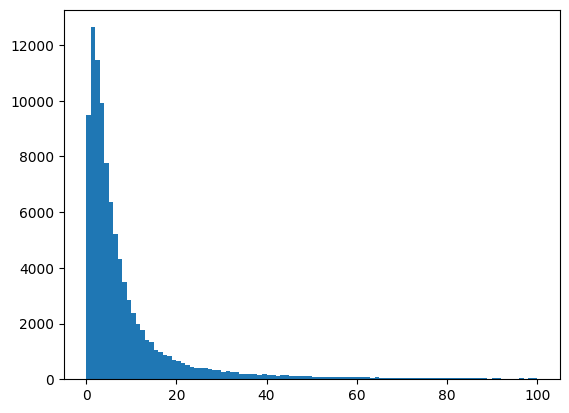

In [4]:
unlensed_params = load_json('samplesL1.json')
snr = np.array(unlensed_params['L1'])
len(snr)
import matplotlib.pyplot as plt
plt.hist(snr[snr<100], bins=100)
plt.show()

In [5]:
# get half_snr 
# open pickle file
import pickle
with open('./interpolator_pickle/L1/halfSNR_dict_0.pickle', 'rb') as f:
    half_snr = pickle.load(f)

In [19]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(gwsnr_verbose=False, minimum_frequency=10.)

psds not given. Choosing bilby's default psds
Interpolator will be generated for L1 detector at ./interpolator_pickle/L1/halfSNR_dict_2.pickle
Interpolator will be generated for H1 detector at ./interpolator_pickle/H1/halfSNR_dict_2.pickle
Interpolator will be generated for V1 detector at ./interpolator_pickle/V1/halfSNR_dict_2.pickle
Please be patient while the interpolator is generated
Generating interpolator for ['L1', 'H1', 'V1'] detectors


interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [01:28<00:00,  1.76s/it]


In [20]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    det_idx = 0 # L1

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_halfsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]
    phi_12 = np.array(params['phi_12'])[idx]
    phi_jl = np.array(params['phi_jl'])[idx]

    # input data
    # X = np.vstack([L1, amp0, Mc, eta, theta_jn, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    X = np.vstack([snr_half_[det_idx], amp0[det_idx], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T

    # output data
    # get L1 snr for y train 
    y = snr[idx]

    return(X,y)

In [21]:
# training set
unlensed_params.keys()

dict_keys(['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'ra', 'dec', 'psi', 'phase', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'geocent_time', 'L1', 'H1', 'V1', 'optimal_snr_net'])

In [22]:
# snr_min = 6.
# snr_max = 10.
# bool_ = (snr>snr_min) & (snr<snr_max) 

len_ = len(snr)
idx = np.arange(len_)
# randomize the train set
idx = np.random.choice(idx, len(idx), replace=False)

In [23]:
X, y = input_output(idx, unlensed_params)

In [24]:
np.shape(X)

(100000, 9)

## Now back to ANN

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [26]:
print(np.shape(X_train))
print(np.shape(X_test))

(80000, 9)
(20000, 9)


In [27]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [28]:
X_train[0]

array([ 0.30465758, -0.04696796, -0.2789885 ,  0.63293202, -1.35328141,
        0.36040427, -1.40198665, -0.03385537,  0.61397705])

In [29]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [30]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [31]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100, workers=4, use_multiprocessing=True)

Epoch 1/100
2500/2500 [==============================] - 1s 492us/step - loss: 132436.2969 - accuracy: 3.7500e-05
Epoch 2/100
2500/2500 [==============================] - 1s 494us/step - loss: 131804.0156 - accuracy: 1.8750e-04
Epoch 3/100
2500/2500 [==============================] - 1s 516us/step - loss: 131226.6094 - accuracy: 1.2500e-04
Epoch 4/100
2500/2500 [==============================] - 1s 506us/step - loss: 130678.3594 - accuracy: 3.5000e-04
Epoch 5/100
2500/2500 [==============================] - 1s 497us/step - loss: 130197.0078 - accuracy: 4.3750e-04
Epoch 6/100
2500/2500 [==============================] - 1s 502us/step - loss: 129728.4453 - accuracy: 6.3750e-04
Epoch 7/100
2500/2500 [==============================] - 1s 556us/step - loss: 129298.8906 - accuracy: 8.0000e-04
Epoch 8/100
2500/2500 [==============================] - 1s 507us/step - loss: 128897.1250 - accuracy: 0.0010
Epoch 9/100
2500/2500 [==============================] - 1s 509us/step - loss: 128522.1484 -

In [32]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:20])

625/625 [==============================] - 0s 275us/step
[[ 2.90637207  2.77783652]
 [ 4.79985046  2.6934239 ]
 [ 5.78448486  5.16251817]
 [58.72959137 46.3247993 ]
 [ 2.92173004  2.15959324]
 [-0.31486511  1.17218455]
 [10.77792358 12.43385128]
 [ 2.71967316  3.39174388]
 [ 5.32328796  4.75306197]
 [ 1.47682953  1.34130512]]


In [33]:
idx = (y_test>4) & (y_test<100)

20000
10825


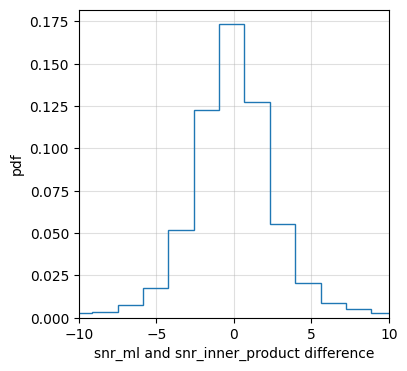

In [34]:
import matplotlib.pyplot as plt
hist_ = y_pred.flatten()-y_test
print(len(hist_))
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
plt.xlim(-10,10)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

ValueError: continuous is not supported